In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, StratifiedKFold, GridSearchCV
import seaborn as sns
import xgboost as xgb
%matplotlib inline

df = pd.read_csv('sac_animals.csv', parse_dates=True)

In [2]:
df.outcome_type.value_counts()
df = df[df['outcome_type'].isin(['ADOPTION' ,'FOSTER', 'RTO', 'EUTH', 'TRANSFER', 'RTF', 'DIED', 'EUTH VET'])]
df = df[df['days_spent'] > 0]

In [3]:
c_data = df[['animal_type', 'animal_sex_clean', 'animal_intake_status', 'name_unknown', 'has_activity_number',
            'animal_age_in_days', 'intake_type', 'color_clean', 'intake_times', 'days_spent']]
c_data = c_data.dropna()

x = c_data.drop('days_spent', axis=1)
x = x.apply(LabelEncoder().fit_transform)
y = c_data['days_spent']

In [4]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=99)

In [5]:
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, [y.mean()] * len(y_test)))

Mean squared error: 526.01


In [6]:
lr = LinearRegression()
lr.fit(x_train, y_train)
y_pred_lr = lr.predict(x_test)

print('Coefficients: \n', lr.coef_)

print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred_lr))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred_lr))

Coefficients: 
 [ 1.5544432   0.06405618  3.57622503 -3.08650014 -0.07197393  0.15101681
 -0.63954735  0.19273154 -2.88609108]
Mean squared error: 514.26
Coefficient of determination: 0.02


In [7]:
params = {'n_estimators': 100,
          'max_depth': 6,
          'min_samples_split': 5,
          'learning_rate': 0.1,
          'loss': 'ls',
           'random_state': 0}

gbr = GradientBoostingRegressor(**params).fit(x_train, y_train)
y_pred_gbr = gbr.predict(x_test)

print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred_gbr))

print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred_gbr))

Mean squared error: 339.24
Coefficient of determination: 0.36


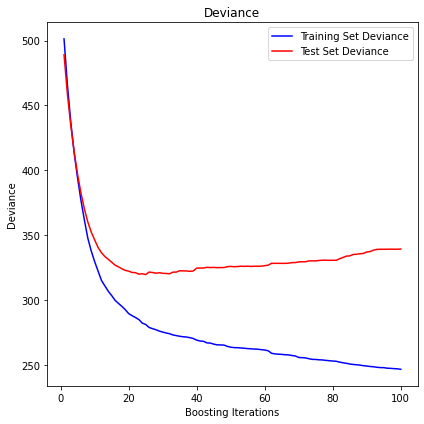

In [8]:
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)
for i, y_pred in enumerate(gbr.staged_predict(x_test)):
    test_score[i] = gbr.loss_(y_test, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, gbr.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')
fig.tight_layout()
plt.show()

Looks like we're suffering from overfitting

In [9]:
xgbr = xgb.XGBRegressor(verbosity=1, n_estimators=200, max_depth=10, reg_alpha=0)
xgbr.fit(x_train, y_train)
score = xgbr.score(x_train, y_train)  
print("Training score: ", score)

Training score:  0.6830049212097641


In [10]:
ypred = xgbr.predict(x_test)
mse = mean_squared_error(y_test, ypred)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % (mse**(1/2.0)))

MSE: 453.30
RMSE: 21.29


Now it really seems like overfitting

In [11]:
xgb_cv = GridSearchCV(estimator=xgbr, param_grid=dict(max_depth=[2, 4],
                                                     min_child_weight=[7, 8, 9],
                                                     reg_alpha=[0, 0.2, 0.5],
                                                     reg_lambda=[0, 0.2, 0.5]),
                         return_train_score=True)

xgb_cv.fit(x_train, y_train)

results = pd.DataFrame(xgb_cv.cv_results_)
results.sort_values(by='rank_test_score', ascending=True, inplace=True)
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_child_weight,param_reg_alpha,param_reg_lambda,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
19,0.162489,0.003455,0.003716,0.000415,2,9,0,0.2,"{'max_depth': 2, 'min_child_weight': 9, 'reg_a...",0.386995,...,0.368501,0.064766,1,0.402118,0.396235,0.433444,0.391395,0.399147,0.404468,0.014914
22,0.184207,0.017060,0.004082,0.000587,2,9,0.2,0.2,"{'max_depth': 2, 'min_child_weight': 9, 'reg_a...",0.387158,...,0.368196,0.065616,2,0.401885,0.395832,0.433802,0.390975,0.399176,0.404334,0.015177
13,0.180043,0.027676,0.003477,0.000027,2,8,0.2,0.2,"{'max_depth': 2, 'min_child_weight': 8, 'reg_a...",0.388079,...,0.368171,0.064958,3,0.403400,0.394489,0.433794,0.391275,0.399612,0.404514,0.015221
26,0.164697,0.014730,0.003590,0.000455,2,9,0.5,0.5,"{'max_depth': 2, 'min_child_weight': 9, 'reg_a...",0.385449,...,0.367857,0.065190,4,0.402286,0.395753,0.433627,0.391605,0.398380,0.404330,0.015056
21,0.167220,0.016250,0.004123,0.000515,2,9,0.2,0,"{'max_depth': 2, 'min_child_weight': 9, 'reg_a...",0.386080,...,0.367751,0.065673,5,0.401380,0.395939,0.433063,0.391127,0.398862,0.404074,0.014890


<AxesSubplot:xlabel='days_spent', ylabel='Count'>

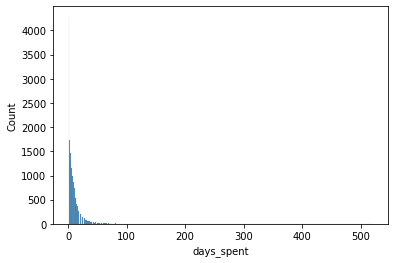

In [15]:
sns.histplot(x=df.days_spent)

Looks like we have some outliers

In [12]:
print(df.days_spent.min())
print(df.days_spent.max())
print(df.days_spent.mean())
print(df.days_spent.median())
print(df.days_spent.std())

1
521
11.712066687924201
6.0
23.212324263224737


In [14]:
#Try without outliers
print(len(c_data[c_data['days_spent'] >= 100]))
print(len(c_data))

197
21953


In [15]:
c_data_remove_outliers = c_data[c_data['days_spent'] < 100]

In [16]:
x_no_outliers = c_data_remove_outliers.drop('days_spent', axis=1)
x_no_outliers = x_no_outliers.apply(LabelEncoder().fit_transform)
y_no_outliers = c_data_remove_outliers['days_spent']

In [17]:
x_train, x_test, y_train, y_test = train_test_split(x_no_outliers, y_no_outliers, test_size=0.33, random_state=99)

In [18]:
xgbr = xgb.XGBRegressor(verbosity=1, n_estimators=200, max_depth=10, reg_alpha=0)
xgbr.fit(x_train, y_train)
score = xgbr.score(x_train, y_train)  
print("Training score: ", score)

Training score:  0.41268209600660477


In [19]:
xgb_cv = GridSearchCV(estimator=xgbr, param_grid=dict(max_depth=[2],
                                                     min_child_weight=[7, 8, 9],
                                                     reg_alpha=[0, 0.2, 0.5],
                                                     reg_lambda=[0, 0.2, 0.5]),
                         return_train_score=True)

xgb_cv.fit(x_train, y_train)

results = pd.DataFrame(xgb_cv.cv_results_)
results.sort_values(by='rank_test_score', ascending=True, inplace=True)
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_child_weight,param_reg_alpha,param_reg_lambda,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
20,0.166602,0.005622,0.003652,0.000201,2,9,0,0.5,"{'max_depth': 2, 'min_child_weight': 9, 'reg_a...",0.116246,...,0.137660,0.011233,1,0.166505,0.157728,0.158469,0.162292,0.160713,0.161141,0.003133
19,0.176016,0.010460,0.004218,0.000797,2,9,0,0.2,"{'max_depth': 2, 'min_child_weight': 9, 'reg_a...",0.115927,...,0.137623,0.011524,2,0.165574,0.158167,0.159183,0.162165,0.160101,0.161038,0.002623
2,0.165451,0.012512,0.003353,0.000116,2,7,0,0.5,"{'max_depth': 2, 'min_child_weight': 7, 'reg_a...",0.116161,...,0.137464,0.011157,3,0.166423,0.158589,0.159421,0.162481,0.159882,0.161359,0.002847
16,0.184142,0.008062,0.003666,0.000092,2,8,0.5,0.2,"{'max_depth': 2, 'min_child_weight': 8, 'reg_a...",0.116161,...,0.137459,0.011199,4,0.166130,0.159214,0.158742,0.162121,0.160264,0.161294,0.002682
6,0.182668,0.045908,0.003562,0.000385,2,7,0.5,0,"{'max_depth': 2, 'min_child_weight': 7, 'reg_a...",0.116298,...,0.137383,0.011104,5,0.166619,0.159214,0.159186,0.162400,0.159226,0.161329,0.002920


We actually do worse without the outliers...

<AxesSubplot:xlabel='days_spent', ylabel='Probability'>

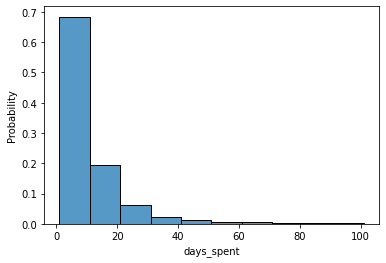

In [22]:
sns.histplot(x=c_data_remove_outliers.days_spent, binwidth=10, stat='probability')

It appears rather than the outliers being the problem, the problem might be lack of variance in our data because nearly 70% of our observations fall between 0 and 10 days. How do we solve this? Should we bucket our days seeing this and try to predict using a classifier instead?